# Problem set 5 - Solutions

## Problem 1)

Since the potential depends only on the radial distance, this problem can be solved in 1D (or 2D in cartesian coordinates, which is my choice). The first step is to think of the xy-plane as a matrix, where $i$ will cover the $y$-coordinate, and $j$ will cover the $x$-coordinate.

The goal is to find a matrix containing the value of V at each point ($i,j$) => $V(i,j)$. The idea is:
- guess the matrix $V_0$
- use it to update to a new matrix $V_1$
- we want it to converge to some set of values
How exactly?

A reminder:

The first derivative of a function $f$ can be estimated as:

\begin{equation}
f'(x) \approx \frac{f(x+h)-f(x)}{h} \approx \frac{f(x)-f(x-h)}{h} 
\end{equation}

and the second derivative:

\begin{equation}
f''(x) \approx \frac{f'(x+h)-f'(x)}{h} \approx \frac{f'(x)-f'(x-h)}{h} 
\end{equation}

inserting $f'(x)$:

\begin{equation}
f''(x) \approx \frac{f(x+h)-2f(x)+f(x-h)}{h^2}  
\end{equation}

In our case, $f$ is the potential and it depends on $x$ and $y$, so...

\begin{equation}
\frac{\partial^2 V }{\partial x^2} \approx \frac{V(x+h,y)-2V(x,y)+V(x-h,y)}{h^2} 
\end{equation}

\begin{equation}
\frac{\partial^2 V }{\partial y^2} \approx \frac{V(x,y+h)-2V(x,y)+V(x,y-h)}{h^2} 
\end{equation}

The potential is solved with the poisson equation:

\begin{equation}
\nabla^2 V = \frac{- \rho}{\varepsilon_0}
\end{equation}
or:

\begin{equation}
\frac{\partial^2 V }{\partial x^2} + \frac{\partial^2 V }{\partial y^2} = \frac{- \rho}{\varepsilon_0}
\end{equation}

Substituting the second derivative approximations in the poisson equation, and solving for $V(x,y)$:

\begin{equation}
V(x,y) = \frac{1}{4} \Big(V(x+h,y)+V(x-h,y)+V(x,y+h)+V(x,y-h) + \frac{\rho(x,y)}{\varepsilon_0}h^2 \Big)
\end{equation}

or translated into matrix indices:

\begin{equation}
V_{i,j} = \frac{1}{4} \Big(V_{i,j+1}+V_{i,j-1}+V_{i+1,j}+V_{i-1,j} + \frac{\rho_{i,j}}{\varepsilon_0}h^2 \Big)
\end{equation}

We will use this equation to estimate the potential everyhwere. Also, we know the boundary conditions:

\begin{equation}
V_{0,L} = V_{0,0} = V_{L,0} = V_{L,L} = 0
\end{equation}

where $L$ is the size of the box, and since the cylinder is held at some potential $V_0$:

\begin{equation}
V[x^2 + y^2 < R^2] = V_0
\end{equation}

where $R$ is the radius of the cylinder.

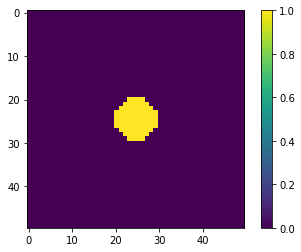

In [800]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show


# First set the configuration of the problem: a cylinder at potential V0 inside a box, which boundaries
# are at potenital V=0. Because the potential depends only on the radial distance, this problem
# can be approached in 2D, cutting a 'slice' -> square instead of box, -> circle instead of cylinder.
# Dimensions are: L = box size, N = number of cells
L = 10.0 
N = 50
# Circle radius
rc = 1.0
# Distance between grid points
ds = L/N
# If the center of the grid is at the center of the circle
x = np.linspace(-L//2, L//2, N)
y = x.copy()
X,Y = np.meshgrid(x,y)
# Now set the potential at the circle and build the matrix V
V0 = 1.0
V = np.zeros((N,N))
V[np.where(np.sqrt(X**2 + Y**2) < rc)] = V0

# Plot to see how it looks like
#cs = plt.pcolormesh(X, Y, V)
plt.imshow(V)
plt.colorbar()


Because we want to solve the potential everywhere (except were we know its value, at the boundaries), we need to solve the equation:

\begin{equation}
V(r) = - \int E \cdot dr = - \int \frac{1}{r} \cdot dr = \frac{-\lambda}{2\pi\epsilon_0} \ln(r) + C
\end{equation}

where $C$ and $\lambda$ are found with the boundary conditions:
- V = 0 at the edges of the square
- V = V0 at the edge of the circle
this means:

\begin{equation}
V(r=R) =  \frac{-\lambda}{2\pi\epsilon_0} \ln(R) + C = 0
\end{equation}

with $R$ the size of the square. And:

\begin{equation}
V(r=r_c) =  \frac{-\lambda}{2\pi\epsilon_0} \ln(r_c) + C = V_0
\end{equation}

with $r_c$ the radius fo the circle. Solving for $C$ and $\lambda$:

\begin{equation}
\lambda  = 2\pi\epsilon_0 V_0 (\ln(R)-\ln(r_c))^{-1}
\end{equation}

and 

\begin{equation}
C  = V_0 (\ln(R)-\ln(r_c))^{-1} \ln(R)
\end{equation}

Note that to solve this problem, we will approximate the square as a circle of radius $\frac{R}{\sqrt{2}}$, which is the distance from the center of the square to one of its corners.

Analytic charge density is 3.212243536636325


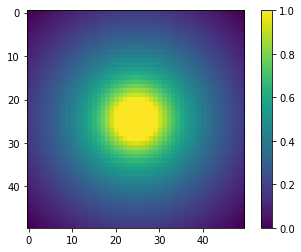

In [806]:
# Find C and lambda, set epsilon0=1. Because the size of the box is L, R will be the radius of the big circle
R = L/np.sqrt(2)
C = V0*np.log(R)/(np.log(R)-np.log(rc))
lamb = 2*np.pi*V0/(np.log(R)-np.log(rc))
print('Analytic charge density is', lamb)

Vanalytic = V.copy()

for i in range(len(x)):
    for j in range(len(x)):
        r = np.sqrt(x[i]**2+y[j]**2)
        # solve only outside the circle
        if r > rc:
            Vanalytic[i,j] = (-lamb/(2*np.pi))*np.log(r)+C

# Plot the analytic solution
#cs2 = plt.contourf(X,Y,Vanalytic,50)
plt.imshow(Vanalytic)
plt.colorbar()


iterations = 3125


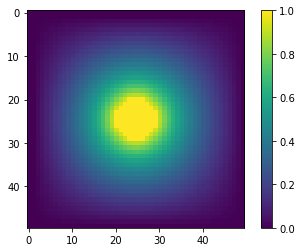

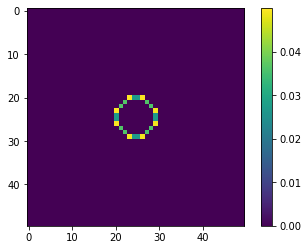

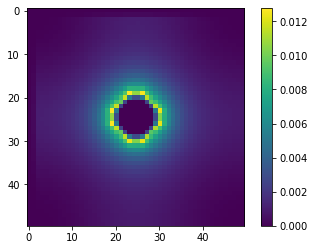

In [802]:
# Now use the relaxation method to build the V matrix

iterations = 0
eps = 1e-8 # Convergence threshold 
error = 1e4 # Large dummy error
while iterations < 1e4 and error > eps:
    V_temp = np.copy(V)
    error = 0 # we make this accumulate in the loop for j in range(2,N-1):
    for j in range(2,N-1):
        for i in range(2,N-1):
            r = np.sqrt(x[j]**2+y[i]**2)
            # solve only outside the circle
            if r > rc:
                # this is the Jacobi method
                V[i,j] = 0.25*(V_temp[i+1,j] + V_temp[i-1,j]+V_temp[i,j-1] + V_temp[i,j+1])
                # reset boundary conditions
                V[:,0]=0
                V[:,-1]=0
                V[1,:]=0
                V[-1,:]=0
                V[np.where(np.sqrt(X**2 + Y**2) < rc)] = V0
                # calculate error
                error += abs(V[i,j]-V_temp[i,j])
    iterations += 1
    error /= float(N)

print("iterations =",iterations)
# Plotting 
#CS = plt.contourf(X,Y,V,50)
plt.imshow(V)
plt.colorbar()

# To calculate rho:
rho = np.zeros((N,N))

for j in range(2,N-1):
        for i in range(2,N-1):
            rho[i,j] = V[i,j] - 0.25*(V[i+1,j] + V[i-1,j]+V[i,j-1] + V[i,j+1])
            
# Plotting 
plt.figure()
#plt.contourf(X,Y,rho)
plt.imshow(rho)
plt.colorbar()

# Check that the electric field is 0 inside the conductor

E = np.gradient(V)
Emag = E[0]**2+E[1]**2
plt.figure()
#plt.contourf(X,Y,Emag)
plt.imshow(Emag)
plt.colorbar()

- First plot: the potential everywhere
- Second plot: this is how the charge density looks like
- Third plot: the electric field

In [807]:
# calculate the charge density per unit length
charge_dens = np.sum(rho)
print('Charge density is:', charge_dens)

Charge density is: 0.9033287442916236


The analytic charge density is 3.5 larger than the estimated with the relaxation method!

## Problem 2)

# The Conjugate Gradient method

The Conjugate Gradient (CG) method solves the system of equations $Ax=b$, where:
- x is a vector
- A is a n x n matrix being symmetric ($A^T=A$), positive definite ($x^T Ax>0$) and real
- the solution of the system are the vectors $x$*

Why $conjugate$???

First...

Two vectors $u$ and $v$ are mutually orthogonal if:

\begin{equation}
(u,v) = u^T v = 0
\end{equation}
where $(u,v)$ is the inner product.

We will say that two vectors $u$ and $v$ are $conjugate$ with respect to $A$, if:

\begin{equation}
u^T A v = 0
\end{equation}

where the left side is the inner product $(u,Av)$. So, the two vectors are conjugate when they are orthogonal with respect this inner product.

Let's take a set of conjugate vectors, to which we call P:
\begin{equation}
P = {p_1,p_2,.....,p_n}
\end{equation}
since they are all orthogonal, they form a basis $\mathbb{R}^n$. But why do we care about them? 

The idea of the CG method is to find the solution, similar to the steepest descent method, but always choosing an orthogonal direction to the previous directions taken to find the minimum. In this way, the zigzag from the steepest descent is avoided, and the minimum is found in a more efficient way. Thus, the $P$ basis encodes the directions we take.
In this basis, the solution $x$* to $Ax=b$ may be written as the linear combination:

\begin{equation}
x^* = \sum_{i=1}^{n} \alpha_i p_i
\end{equation}

Multiplying by $A$ and then by $p_k^T$:

\begin{equation}
p_k^T Ax^* = \sum_{i=1}^{n} \alpha_i p_k^T A p_i
\end{equation}

Because $Ax*=b$, and using $u^T A v = (u,v)$:

\begin{equation}
p_k^T b = \sum_{i=1}^{n} \alpha_i (p_k, p_i)_A
\end{equation}

Since the $p$ vectors are orthogonal:

\begin{equation}
p_k^T b = \alpha_i (p_k, p_k)_A
\end{equation}

and finally, using $u^T v = (u,v)$:

\begin{equation}
(p_k, b) = \alpha_i (p_k, p_k)_A
\end{equation}

with this equation, we obtain the coefficients $\alpha_i$:

\begin{equation}
\alpha_i = \frac{(p_k, b)}{(p_k, p_k)_A}
\end{equation}


## As an iterative method

Start with an initial guess of the solution $x^*$, say $x_0$

Because $x^*$ is the unique minimizer to the quatratic function:

\begin{equation}
f(x) = \frac{1}{2} x^T A x - x^T b
\end{equation}

with
\begin{equation}
\nabla f(x) =  A x - b
\end{equation}
\begin{equation}
\nabla^2 f(x) =  A
\end{equation}

We start by taking the first "direction" vector, $p_0$, which will be the negative gradient of the function $f$:

\begin{equation}
p_0 = - \nabla f(x_0) =  -A x_0 + b
\end{equation}

the other vectors in the basis $P$ will be conjugate to $p_0$. The residual provided by this first step will be $p_0$. So, the $k$-th residual is:

\begin{equation}
r_k = b -A x_k
\end{equation}

As we said, this method has the advantage that the new direction towards the minimum is orthogonal to all the previous directions taken before. This is achieved by taking the new direction according to the residual, imposing the following constrain:


\begin{equation}
p_k = r_k - \sum_{i<k} \frac{p_i^T A r_k}{p_i^T A p_i} p_i
\end{equation}

If we follow this direction, the next optimal position is:

\begin{equation}
x_{k+1} = x_k + \alpha_k p_k
\end{equation}

where $\alpha$ was defined above, as:

\begin{equation}
\alpha_k = \frac{p_k^T (b-Ax_k)}{p_k^T A p_k} = \frac{p_k^T r_k}{p_k^T A p_k}
\end{equation}

## The algorithm

- define the initial guess $x_0$, which may be 0
- compute $r_0 = b - Ax_0 $
- $p_0 = r_0$
- repeat over k
- compute $\alpha_k = \frac{r_k^T r_k}{p_k^T A p_k}$
- following position: $x_{k+1} = x_k + \alpha_k p_k$
- following residual: $r_{k+1} = r_k - \alpha_k A p_k$
- if $r_{k+1}$ is small, exit loop and return $x_{k+1}$
- compute the "following $\alpha$", to which we call $\beta$: $\beta_{k} = \frac{r_{k+1}^T r_{k+1}}{r_{k}^T A r_{k}}$
- get following direction: $p_{k+1} = r_{k+1}+\beta_k p_k$
- return $x_{k+1}$ 

So, the solution $x$ will be the value of the potential at each position.

rsqr on iter  60  is  6.3933270939335415e-09


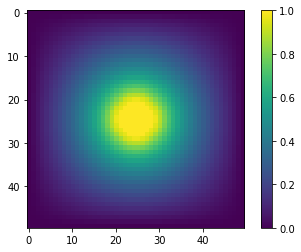

In [809]:
# Solves the left side of the equation
def Ax(V,mask):
    Vuse=V.copy()
    Vuse[mask]=0
    ans=(Vuse[1:-1,:-2]+Vuse[1:-1,2:]+Vuse[2:,1:-1]+Vuse[:-2,1:-1])/4.0
    ans=ans-V[1:-1,1:-1]
    return ans

# This function fills the matrix A with zeros at the edges
# and it's necessary because each time we estimate V on its surroundings
# it doesn't take into account the edges

def pad(A):
    AA=np.zeros([A.shape[0]+2,A.shape[1]+2])
    AA[1:-1,1:-1]=A
    return AA

# This parameters are the same that before
L = 10.0 
N = 50
rc = 1.0
V0 = 1.0

# First create the mask and the matrix with the boundary conditions
bc = np.zeros((N,N))
x = np.linspace(-L//2, L//2, N)
y = x.copy()
X,Y = np.meshgrid(x,y)

mask = np.sqrt(X**2 + Y**2) < rc
bc[mask] = V0
mask[:,0]=True
mask[:,-1]=True
mask[0,:]=True
mask[-1,:]=True

V=np.zeros((N,N))

# The function that implements conjugate gradient and returns V solved everywhere
def cg(bc,V,mask,niter):
    b = -(bc[1:-1,0:-2]+bc[1:-1,2:]+bc[:-2,1:-1]+bc[2:,1:-1])/4.0
    r=b-Ax(V,mask)
    p=r.copy()
    rsqr=np.sum(r*r)
    for k in range(niter):
        Ap=Ax(pad(p),mask)
        alpha=np.sum(r*r)/np.sum(Ap*p)
        V=V+pad(alpha*p)
        r=r-alpha*Ap
        rsqr_new=np.sum(r*r)
        beta=rsqr_new/rsqr
        p=r+beta*p
        rsqr=rsqr_new
        if rsqr<1e-8:
            print('rsqr on iter ',k,' is ',rsqr)
            break  
    return V

Vsolved = cg(bc,V,mask,100)
#CS = plt.contourf(X,Y,Vsolved,50)
plt.imshow(Vsolved)
plt.colorbar()

With a threshold of $10^{-8}$ the number of iterations is 60, compared to 3125 using the relaxation method. 

## Problem 3)

rsqr on iter  37  is  4.562245239312066e-09


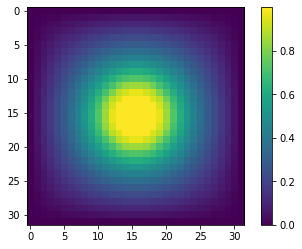

In [810]:
def deres_mat(mat):
    '''
    A function that receives the matrix and changes its resolution, decreasing
    it by a factor 2
    '''
    #print('mat shape',mat.shape[0])
    #print(int(mat.shape[0]/2))
    #print(int(mat.shape[1]/2))
    mm=np.zeros([mat.shape[0]//2,mat.shape[1]//2],dtype=mat.dtype)
    #print('mm shape',mm.shape[0])
    #print('2:2',mat[::2,::2].shape)
    # [::2] takes even index
    # [1::2] takes odd index
    mm=np.maximum(mm,mat[::2,::2])
    mm=np.maximum(mm,mat[::2,1::2])
    mm=np.maximum(mm,mat[1::2,::2])
    mm=np.maximum(mm,mat[1::2,1::2])
    return mm
def upres_mat(mat):
    '''
    A function that receives the matrix and changes its resolution, increasing
    it by a factor 2
    '''
    mm=np.zeros([mat.shape[0]*2,mat.shape[1]*2],dtype=mat.dtype)
    mm[::2,::2]=mat
    mm[::2,1::2]=mat
    mm[1::2,::2]=mat
    mm[1::2,1::2]=mat
    return mm

# define the bc and mask
L = 10.0 
N = 1024
rc = 1.0
V0 = 1.0

bc = np.zeros((N,N))
x = np.linspace(-L//2, L//2, N)
y = x.copy()
X,Y = np.meshgrid(x,y)

mask = np.sqrt(X**2 + Y**2) < rc
bc[mask] = V0
mask[:,0]=True
mask[:,-1]=True
mask[0,:]=True
mask[-1,:]=True

V=np.zeros((N,N))


npass=6
#loop through the resolutions.  In this case, start with something 2**6 times coarser than the desired resolution
#solve it, and then increase the resolution by a factor of 2.  Solve the next-higher resolution problem using that
#as the starting guess.
all_masks=[None]*npass
all_bc=[None]*npass
all_x=[None]*npass
all_masks[0]=mask
all_bc[0]=bc
for i in range(1,npass):
    all_masks[i]=deres_mat(all_masks[i-1])
    all_bc[i]=deres_mat(all_bc[i-1])

#now, make the lowest-resolution map.  First set up the RHS given the low-res boundary conditions/masks we already made.

nn=all_masks[-1].shape[0] #.shape[0] gives the dimension of the array, the number of elements
niter=3*nn

all_x[-1]=cg(all_bc[-1],0*all_bc[-1],all_masks[-1],niter)

#show our lowest-resolution solution
plt.ion()
plt.imshow(all_x[-1])
plt.colorbar()

For a low resolution, it takes 37 iterations to converge with the same threshold from part 2.

rsqr on iter  64  is  7.805696519214264e-09


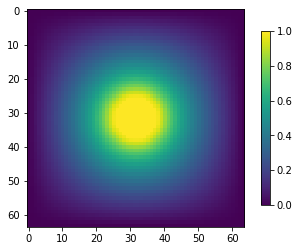

rsqr on iter  110  is  9.117031063699718e-09


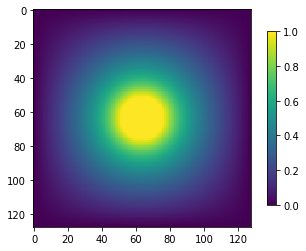

rsqr on iter  106  is  9.940518942138003e-09


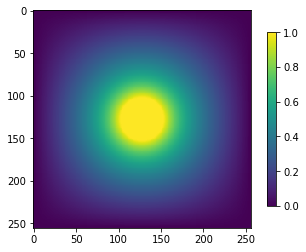

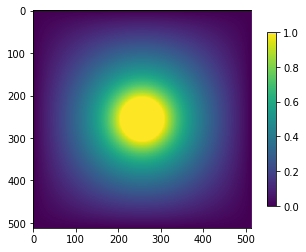

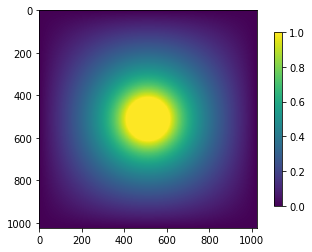

<Figure size 432x288 with 0 Axes>

In [812]:
#and now, run a loop where you increase the resolution, solve for a fixed number of iterations, then repeat until 
#you're at your desired resolution.  The hardwired number of iterations is rather sloppy, but gets the job done.
niter=150

for i in range(npass-2,-1,-1):
    x0=upres_mat(all_x[i+1])
    all_x[i]=cg(all_bc[i],x0,all_masks[i],niter)
    #plot the current-resolution potential
    plt.clf()
    CS = plt.imshow(all_x[i])
    CB = plt.colorbar(CS, shrink=0.8)
    plt.pause(0.01)

#finally, paste in the boundary conditions since we didn't solve for them in conjugate gradient.
for i in range(npass):
    all_x[i][all_masks[i]]=all_bc[i][all_masks[i]]

plt.clf()
#plt.contourf(X,Y,all_x[0],50)
#plt.imshow(all_x[0])
#plt.colorbar(shrink=0.8)

## Problem 4)

In [813]:
# Add a bump of 10% the size of the circle
# centered on the edge of the circle, at some value of x
L = 10.0 
N = 1024
rc = 1.0
V0 = 1.0

bc = np.zeros((N,N))
x = np.linspace(-L//2, L//2, N)
y = x.copy()
X,Y = np.meshgrid(x,y)

mask = np.sqrt(X**2 + Y**2) < rc
bump = np.sqrt((X)**2 + (Y-rc)**2) < (rc/10)
bc[mask] = V0
bc[bump] = V0
mask = np.bool_(bc)
mask[:,0]=True
mask[:,-1]=True
mask[0,:]=True
mask[-1,:]=True

V=np.zeros((N,N))

rsqr on iter  37  is  4.562245239312066e-09
rsqr on iter  63  is  7.872285163761404e-09


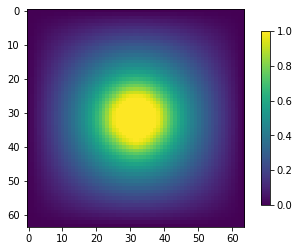

rsqr on iter  112  is  8.563826617064118e-09


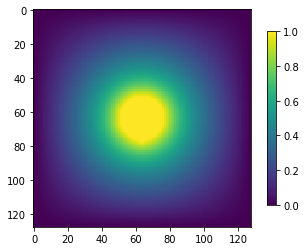

rsqr on iter  144  is  9.673807681829303e-09


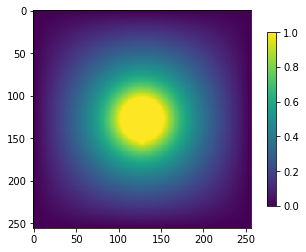

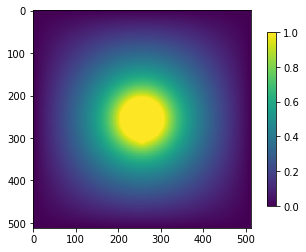

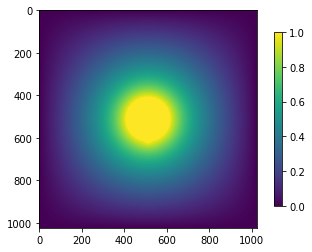

In [815]:
# Same procedure as problem 3

npass=6

all_masks=[None]*npass
all_bc=[None]*npass
all_x=[None]*npass
all_masks[0]=mask
all_bc[0]=bc
for i in range(1,npass):
    all_masks[i]=deres_mat(all_masks[i-1])
    all_bc[i]=deres_mat(all_bc[i-1])

nn=all_masks[-1].shape[0] #.shape[0] gives the dimension of the array, the number of elements
niter=3*nn

all_x[-1]=cg(all_bc[-1],0*all_bc[-1],all_masks[-1],niter)

plt.ion();
CS = plt.imshow(all_x[-1])
CB = plt.colorbar(CS, shrink=0.8)
niter=150

for i in range(npass-2,-1,-1):
    x0=upres_mat(all_x[i+1])
    all_x[i]=cg(all_bc[i],x0,all_masks[i],niter)
    plt.clf()
    CS = plt.imshow(all_x[i])
    CB = plt.colorbar(CS, shrink=0.8)
    plt.pause(0.01)


for i in range(npass):
    all_x[i][all_masks[i]]=all_bc[i][all_masks[i]]

#plt.clf()
#plt.contourf(X,Y,all_x[0],50)
#plt.imshow(all_x[0])
#plt.colorbar(shrink=0.8)

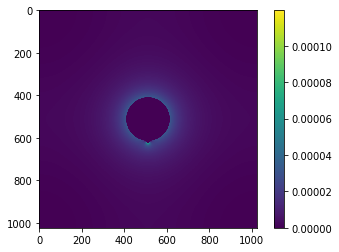

In [816]:
E = np.gradient(all_x[0])
Emag = E[0]**2+E[1]**2
plt.figure()
plt.imshow(Emag)
plt.colorbar()

The electric field near the bump is larger than at the rest of the circle.

## Problem 5)

I will solve this problem in 1D, since by heating only one side of the box, the temperature increases in one direction.

A very useful link that explains how to solve this problem http://www.nada.kth.se/~jjalap/numme/FDheat.pdf

So we want to solve

\begin{equation}
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}
\end{equation}

the solution will give us the temperature at each time step and at each position. A discretized version of this equation is:

\begin{equation}
u_i^{m+1} = u_i^m + \frac{\alpha \Delta t}{\Delta x^2} (u_{i+1}^m - 2u_i^m + u_{i-1}^m)
\end{equation}

where $m$ represents the time step and $i$ the x-position. If we define $r = \frac{\alpha \Delta t}{\Delta x^2}$ the equation can be rewritten as:

\begin{equation}
u_i^{m+1} = r \, u_{i+1}^m + (1-2r)u_i^m+r \, u_{i-1}^m
\end{equation}

The solutions to this equation are stable only if: $r = \frac{\alpha \Delta t}{\Delta x^2} < \frac{1}{2}$

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


"\nx,t,u = solve_u(100,1,0.1,4.5,3,10)\n\nplt.figure()\nplt.plot(x,u[:],'.')\nplt.xlabel('Position')\nplt.ylabel('Temperature')\nplt.show()\nplt.figure()\nplt.plot(t,u[:],'.')\nplt.xlabel('Time')\nplt.ylabel('Temperature')\nplt.show()\n"

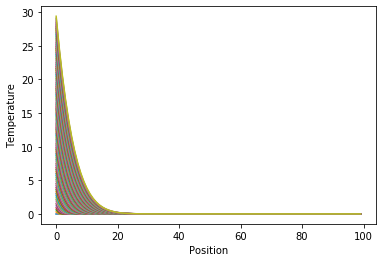

In [788]:
def solve_u(L,dx,dt,alpha,t_wall,tmax):
    # L = size of the box
    #dx = L/(nx-1) # nx is the number of spatial nodes
    #dt = tmax/(nt-1) # nt is the number of time steps    
    x = np.arange(0,L,dx) # array of positions
    t = np.arange(0,tmax,dt) # array of time steps
    u = np.zeros((len(t),len(x))) # saves the value of u at time t and position x
    t_wall = t*t_wall # array with the increasing temperature of the wall with time
    r = alpha*dt/dx**2
    fig = plt.gcf()
    fig.show()
    fig.canvas.draw()
    if r >= 0.5:
        print('solution is not stable!')
    for i in range(len(t)-1): # loops over time
        # u[row,column]=u[t,x]
        u[i,0] = t_wall[i] # set the wall temperature
        for j in range(1,len(x)-1): # loops over space
            u[i+1,j] = r*u[i,j+1]+(1-2*r)*u[i,j]+r*u[i,j-1] # estimate the temperature at next position
        plt.ion()
        plt.plot(x,u[i])
        plt.xlabel('Position')
        plt.ylabel('Temperature')
        fig.canvas.draw()
        #plt.pause(0.001)
    return x,t,u


solve_u(100,1,0.1,4.5,3,10)



In this plot, each curve represents the computed temperature vs position with time (for each time step, a different curve). Because we set the condition that one wall increases its temperature linearly, the top of the curves increases until they reach the maximum temperature.